## Classification de la base n16 en utilisant le deep learning

## 1- CNN

In [36]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
#Importer les données
import os
os.chdir('C:\\Users\\massermouh\\Downloads')
file_name = 'n16.xlsx'
xl_file = pd.ExcelFile(file_name, engine='openpyxl', )
df = xl_file.parse('Feuil1')

#extraire la base de données contenant que les mails reçus

s = '/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GROUP'
s = s.lower()

env_df = df
env_df['From (address)'] = env_df['From (address)'].replace('-', np.nan)
env_df = env_df.dropna(axis=0, subset=['From (address)'])

env_df = env_df[env_df['From (address)'].str.lower().str.contains(s)] 

rec_df = df 
rec_df['From (address)'] = rec_df['From (address)'].replace('-', np.nan)
rec_df = rec_df.merge(env_df, how="left", left_on=df.columns.values.tolist(), right_on=df.columns.values.tolist(), indicator=True)
rec_df = rec_df.query("_merge == 'left_only'")[df.columns.values.tolist()]

# Remplacer les données manquantes par une chaine de caractères vide

rec_df.fillna('',inplace=True)
#rec_df.info()

# création d'un dataframe avec une colonne texte contenant le body le sujet et les expéditeurs

matrice = pd.DataFrame()
matrice["text"] = rec_df['From (address)'].astype(str) + rec_df["Subject"].astype(str) + rec_df["Body"].astype(str)

In [29]:
type(matrice["text"])

pandas.core.series.Series

In [39]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

### Génération des attributs textuels :

messages = matrice["text"]

## Preprocessing : 

#Preprocess text messages

# Replace URLs with 'webaddress'
processed = messages.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
processed = processed.str.replace(r'£|\$', 'moneysymb')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumbr')
    
# Replace numbers with 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove punctuation
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

# change words to lower case 
processed = processed.str.lower()

# remove french stop words from text messages

stop_words = set(stopwords.words('french'))

processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

# remove english stop words from text messages

stop_words = set(stopwords.words('english'))
# stop_words.add('bonjour')
stop_words.add('please')
stop_words.add('mailto')
stop_words.add('mail')
stop_words.add('numbr')
# stop_words.add('cordialement')
stop_words.add('e')
stop_words.add('virus')
stop_words.add('antiphishing')
stop_words.add('merci')
stop_words.add('com')
stop_words.add('fr')
stop_words.add('https')
stop_words.add('bjenumbrywvybnumbrbhcmnaznumbrjvdxbllwlkzweuynumbrt')

processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\massermouh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
labels = np.load( 'n16_labels.npy' )

In [41]:
texts = messages.to_list()

In [11]:
type(texts[0])

str

In [42]:
MAX_SEQUENCE_LENGTH = max([len(d.split()) for d in messages.to_numpy()])
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [43]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 14003


In [44]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (1661, 4167)
Shape of Label Tensor: (1661, 2)


In [29]:
os.getcwd()

'C:\\Users\\massermouh\\Downloads'

In [15]:
embeddings_index = {}
f = open('glove.6B/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [18]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [19]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4167)]            0         
                                                                 
 embedding (Embedding)       (None, 4167, 100)         1400400   
                                                                 
 conv1d (Conv1D)             (None, 4163, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 832, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 828, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 165, 128)         0         
 1D)                 

In [34]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Epoch 1/15
665/665 [==============================] - ETA: 0s - loss: 0.7109 - acc: 0.6614
Epoch 1: val_acc improved from -inf to 0.68373, saving model to model_cnn.hdf5
665/665 [==============================] - 327s 487ms/step - loss: 0.7109 - acc: 0.6614 - val_loss: 0.5645 - val_acc: 0.6837
Epoch 2/15
665/665 [==============================] - ETA: 0s - loss: 0.6165 - acc: 0.7073
Epoch 2: val_acc improved from 0.68373 to 0.74398, saving model to model_cnn.hdf5
665/665 [==============================] - 307s 462ms/step - loss: 0.6165 - acc: 0.7073 - val_loss: 0.5469 - val_acc: 0.7440
Epoch 3/15
665/665 [==============================] - ETA: 0s - loss: 0.6509 - acc: 0.7487
Epoch 3: val_acc improved from 0.74398 to 0.76807, saving model to model_cnn.hdf5
665/665 [==============================] - 215s 323ms/step - loss: 0.6509 - acc: 0.7487 - val_loss: 0.5278 - val_acc: 0.7681
Epoch 4/15
665/665 [==============================] - ETA: 0s - loss: 0.5544 - acc: 0.7750
Epoch 4: val_acc d

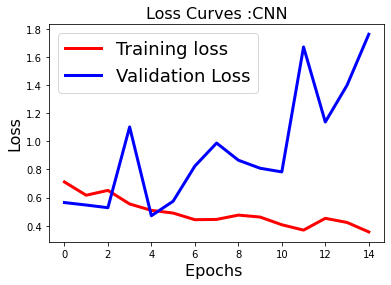

In [35]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

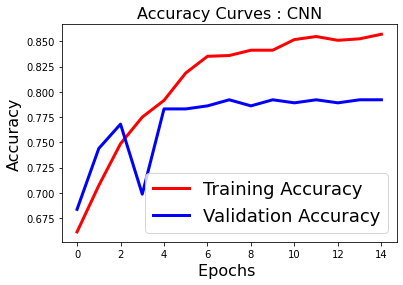

In [36]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

## RNN

In [38]:
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32856)]           0         
                                                                 
 embedding (Embedding)       (None, 32856, 100)        1400400   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 2)                 402       
                                                                 
Total params: 1,561,602
Trainable params: 1,561,602
Non-trainable params: 0
_________________________________________________________________


## Bert

In [27]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [35]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [34]:
#Initializing bert layers

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

ValueError: Exception encountered when calling layer "keras_layer_3" (type KerasLayer).

in user code:

    File "C:\Users\massermouh\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_hub\keras_layer.py", line 237, in call  *
        result = smart_cond.smart_cond(training,

    ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
      Positional arguments (3 total):
        * {'input_mask': <tf.Tensor 'inputs:0' shape=(None, 128) dtype=int32>,
     'input_word_ids': <tf.Tensor 'inputs_1:0' shape=(None, 128) dtype=int32>}
        * False
        * None
      Keyword arguments: {}
    
     Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
        * False
        * None
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
        * False
        * None
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
        * True
        * None
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
        * True
        * None
      Keyword arguments: {}


Call arguments received by layer "keras_layer_3" (type KerasLayer):
  • inputs={'input_mask': 'tf.Tensor(shape=(None, 128), dtype=int32)', 'input_word_ids': 'tf.Tensor(shape=(None, 128), dtype=int32)'}
  • training=False

In [30]:
#Initializing the nn layers
l = tf.keras.layers.Dropout(0.5, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [31]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [47]:
#Model compiling
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [48]:
labels.shape

(1661,)

In [49]:
labels = np.load("n16_labels.npy")

In [50]:
texts = pd.Series(texts)
labels = pd.Series(labels)

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts,labels, stratify=labels)

In [52]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
39/39 [==============================] - 211s 5s/step - loss: 0.6850 - accuracy: 0.5767 - precision: 0.3950 - recall: 0.1629
Epoch 2/10
39/39 [==============================] - 224s 6s/step - loss: 0.6759 - accuracy: 0.5831 - precision: 0.3851 - recall: 0.1175
Epoch 3/10
39/39 [==============================] - 206s 5s/step - loss: 0.6586 - accuracy: 0.6088 - precision: 0.4915 - recall: 0.1196
Epoch 4/10
39/39 [==============================] - 209s 5s/step - loss: 0.6590 - accuracy: 0.6104 - precision: 0.5000 - recall: 0.1505
Epoch 5/10
39/39 [==============================] - 210s 5s/step - loss: 0.6602 - accuracy: 0.5952 - precision: 0.4345 - recall: 0.1299
Epoch 6/10
39/39 [==============================] - 205s 5s/step - loss: 0.6544 - accuracy: 0.6032 - precision: 0.4710 - recall: 0.1505
Epoch 7/10
39/39 [==============================] - 212s 5s/step - loss: 0.6572 - accuracy: 0.5960 - precision: 0.4643 - recall: 0.2412
Epoch 8/10
39/39 [==============================

## Roberta

In [25]:
!pip install --upgrade pip --user

In [26]:
!pip install smaberta

^C


In [22]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random
import torch
import pickle
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

import sys
sys.path.append('../smaberta')
from smaberta import TransformerModel

ModuleNotFoundError: No module named 'smaberta'

## Try again

In [49]:
!pip install simpletransformers==0.28.2

     -------------------------------------- 184.4/184.4 kB 2.8 MB/s eta 0:00:00
  Using cached tensorboardX-2.5-py2.py3-none-any.whl (125 kB)
  Attempting uninstall: simpletransformers
    Found existing installation: simpletransformers 0.63.6
    Uninstalling simpletransformers-0.63.6:
      Successfully uninstalled simpletransformers-0.63.6


In [50]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 4}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "distilbert-base-multilingual-cased",
    num_labels=2,
    args=train_args
)

ModuleNotFoundError: No module named 'transformers.modeling_albert'